In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
%matplotlib inline 
import seaborn as sb

## Preparations

In [2]:
def get_color_gradient(series=None,nbtrials=None, cmap=plt.get_cmap('viridis')):
    if nbtrials is not None:
        series= pd.Series(index=np.arange(0, nbtrials))
        series[:] = np.linspace(0, 1, series.shape[0])

    normalised_values = series.values.copy()
    # substract offset from values, so the smallest one is zero
    normalised_values -= normalised_values.min()
    # all values are zero and have the same value
    if normalised_values.max() > 0:
        #raise ValueError('series.values are constant') 
        # actually normalize the values
        normalised_values = normalised_values / normalised_values.max()
    colors = cmap(normalised_values)
    # create the dataframe from color
    df_colors = pd.DataFrame(
        data=colors, index=series.index, columns=['r', 'g', 'b', 'a'])

    # Create data for colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(
                                   vmin=series.values.min(),
                                   vmax=series.values.max()))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    
    return df_colors, sm


def make_rectangle(obj, width, height, color, alpha):
    """
    use PatchCollection (ugh) to add objects
    in real size to plots
    """
    objects = []
    
    obj = clutter.to_numpy()
    
    for rect in range(len(obj)):
        rectangle = plt.Rectangle((obj[rect, 0]-(width/2), obj[rect, 1]-(height/2)), width=width, height=height) 
        objects.append(rectangle)

    pc = PatchCollection(objects, facecolor=color, alpha=alpha)
    
    return pc

In [3]:
key_template = 'traj_coeff_{}'
key_original = 'traj_original_{}'
hdf_file = 'data_all.hdf'

In [4]:
clutter = pd.read_csv('objects_pos_blender.csv', index_col = 0)
clutter.x = -clutter.x

In [5]:
conditions = pd.read_hdf(hdf_file, key='conditions')
conditions.head()

BeeID  Trial Condition         Filename  keep
0    33      5         0  20191028_113207     1
1    20      7         0  20191028_141719     1
2    20      8         0  20191028_142540     1
3    33      7         0  20191028_153803     1
4    33      8         0  20191029_095201     1

## Plot all trajectories, unlabeled

In [6]:
fig,ax = plt.subplots(1,1, figsize=(15,10))
ax.set_aspect('equal')

    
for idx,trajname in enumerate(conditions.Filename):

    traj = pd.read_hdf(hdf_file, key=key_original.format(trajname))
    
    ax.plot(-traj.x, traj.y, color='grey', alpha=0.8)
    ax.set_ylim([-150, 150])       
    

pc = make_rectangle(clutter, 3, 10, 'black', 0.8)
ax.add_artist(pc)

#fig.savefig('figures/resCut.svg')

## Example interpolation and resampling effect

In [7]:
fig,ax = plt.subplots(2,1, figsize=(15,10))
ax = ax.flatten()
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
    

traj = pd.read_hdf(hdf_file, key=key_original.format(conditions.Filename[0]))
traj2 = pd.read_hdf(hdf_file, key=key_original.format(conditions.Filename[2]))

ax[0].plot(-traj.x, traj.y, linestyle='-', marker='x',  color='grey', alpha=0.8)
ax[0].plot(-traj2.x, traj2.y, linestyle='-', marker='x',  color='grey', alpha=0.8)
ax[0].set_ylim([-150, 150])       
    

pc = make_rectangle(clutter, 3, 10, 'black', 0.8)
ax[0].add_artist(pc)




traj = pd.read_hdf(hdf_file, key=key_template.format(conditions.Filename[0]))
traj2 = pd.read_hdf(hdf_file, key=key_template.format(conditions.Filename[2]))

ax[1].plot(-traj.x, traj.y, linestyle='-', marker='x',  color='grey', alpha=0.8)
ax[1].plot(-traj2.x, traj2.y, linestyle='-', marker='x',  color='grey', alpha=0.8)
ax[1].set_ylim([-150, 150])       


pc = make_rectangle(clutter, 3, 10, 'black', 0.8)
ax[1].add_artist(pc)


#fig.savefig('figures/resResamplingEffect.svg')

# Classification trajectories K = 4 

In [8]:
res_annon = pd.read_csv('results/M3C/simMeasures/res_all_annon_K4.csv', index_col=0)
res_annon.head()

consensuscluster
traj_coeff_2020_02_10T14_37_25                 1
traj_coeff_2020_02_10T12_52_20                 1
traj_coeff_2020_02_05T09_29_34                 1
traj_coeff_2020_02_04T10_37_58                 1
traj_coeff_20191115_094710                     1

10
24
15
34


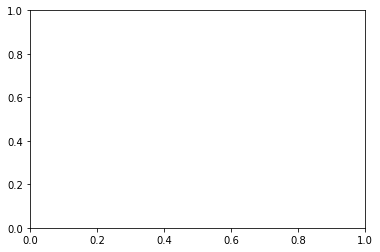

In [9]:
from navipy import trajectories 
from navipy.trajectories.tools import averaged_trajectory

alltraj = dict()

for cluster in range(1, len(res_annon.loc[:,'consensuscluster'].drop_duplicates())+1):

    alltraj[cluster] = []
    listoftraj = res_annon.loc[res_annon.loc[:,'consensuscluster']==cluster,:].index
    print(len(listoftraj))
    
    for idx,trajname in enumerate(listoftraj):

        traj = pd.read_hdf(hdf_file, key=trajname)
        
        traj_navi = trajectories.Trajectory(rotconv='zyx', indeces=traj.index)
        traj_navi.x = traj.x
        traj_navi.y = traj.y
        traj_navi.z = traj.z
        traj_navi.alpha_0 = np.zeros(len(traj)) #can't be NaN, otherwise the consecutive_block function does not work
        traj_navi.alpha_1 = np.zeros(len(traj))
        traj_navi.alpha_2 = np.zeros(len(traj))

        alltraj[cluster].append(traj_navi)

34
24
10
15


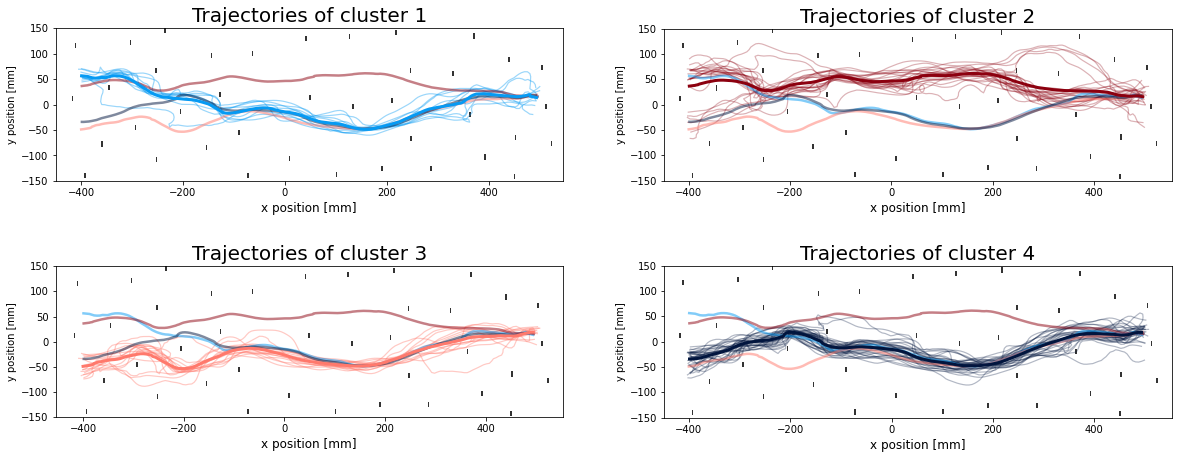

In [10]:
df_colors = ['xkcd:azure', 'xkcd:crimson', 'xkcd:salmon', 'xkcd:navy']

fig,ax = plt.subplots(2,2, figsize=(20,8)) # a bit ugly atm, TODO: grid 
ax = ax.flatten()

ax[0].set_title('Trajectories of cluster 1', fontsize=20)
ax[1].set_title('Trajectories of cluster 2', fontsize=20)
ax[2].set_title('Trajectories of cluster 3', fontsize=20)
ax[3].set_title('Trajectories of cluster 4', fontsize=20)


for cluster in [4,2,1,3]: # changed order for more visibility

    
    listoftraj = res_annon.loc[res_annon.loc[:,'consensuscluster']==cluster,:].index
    print(len(listoftraj))
    
    for idx,trajname in enumerate(listoftraj):

        traj = pd.read_hdf(hdf_file, key=trajname)
        
        # also for more visibility
        if cluster == 3 or cluster == 1:
            ax[cluster-1].plot(-traj.x, traj.y, color=df_colors[cluster-1], alpha=0.4, linewidth=1.2) 
            
        else:
            ax[cluster-1].plot(-traj.x, traj.y, color=df_colors[cluster-1], alpha=0.3, linewidth=1.2)
                    
        
avg_traj1 = averaged_trajectory(alltraj[1])
avg_traj2 = averaged_trajectory(alltraj[2])
avg_traj3 = averaged_trajectory(alltraj[3])
avg_traj4 = averaged_trajectory(alltraj[4])        

ap = 0.5
lw = 2.5

for cluster in [4,2,1,3]: # changed order for more visibility
    
    if cluster == 1:
        ax[cluster-1].plot(-avg_traj2.x, avg_traj2.y, color=df_colors[1], alpha=ap, linewidth=lw)
        ax[cluster-1].plot(-avg_traj3.x, avg_traj3.y, color=df_colors[2], alpha=ap, linewidth=lw)
        ax[cluster-1].plot(-avg_traj4.x, avg_traj4.y, color=df_colors[3], alpha=ap, linewidth=lw)
        
        ax[cluster-1].plot(-avg_traj1.x, avg_traj1.y, color=df_colors[cluster-1], alpha=1, linewidth=3)
        
        
    elif cluster == 2:
        ax[cluster-1].plot(-avg_traj1.x, avg_traj1.y, color=df_colors[0], alpha=ap, linewidth=lw)
        ax[cluster-1].plot(-avg_traj3.x, avg_traj3.y, color=df_colors[2], alpha=ap, linewidth=lw)
        ax[cluster-1].plot(-avg_traj4.x, avg_traj4.y, color=df_colors[3], alpha=ap, linewidth=lw)
        
        ax[cluster-1].plot(-avg_traj2.x, avg_traj2.y, color=df_colors[cluster-1], alpha=1, linewidth=3)
        
        
    elif cluster == 3:
        ax[cluster-1].plot(-avg_traj1.x, avg_traj1.y, color=df_colors[0], alpha=ap, linewidth=lw)
        ax[cluster-1].plot(-avg_traj2.x, avg_traj2.y, color=df_colors[1], alpha=ap, linewidth=lw)
        ax[cluster-1].plot(-avg_traj4.x, avg_traj4.y, color=df_colors[3], alpha=ap, linewidth=lw)
        
        ax[cluster-1].plot(-avg_traj3.x, avg_traj3.y, color=df_colors[cluster-1], alpha=1, linewidth=3)
        
    elif cluster == 4:
        ax[cluster-1].plot(-avg_traj1.x, avg_traj1.y, color=df_colors[0], alpha=ap, linewidth=lw)
        ax[cluster-1].plot(-avg_traj2.x, avg_traj2.y, color=df_colors[1], alpha=ap, linewidth=lw)
        ax[cluster-1].plot(-avg_traj3.x, avg_traj3.y, color=df_colors[2], alpha=ap, linewidth=lw)
        
        ax[cluster-1].plot(-avg_traj4.x, avg_traj4.y, color=df_colors[cluster-1], alpha=1, linewidth=3)
    
    
for i in range(0,4):
    ax[i].set_xlabel('x position [mm]', fontsize=12)
    ax[i].set_ylabel('y position [mm]')
    
    ax[i].set_aspect('equal')
    ax[i].set_ylim([-150, 150])
    
    pc = make_rectangle(clutter, 3, 10, 'black', 0.8)
    ax[i].add_artist(pc)    

#fig.savefig('figures/trajClassificationM3C_avg_sep.svg')